In [ ]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.current_device())
# print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 4060 Laptop GPU


c:\Users\biswa\anaconda3\envs\pytorch_cuda_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#import kagglehub

#kagglehub.login()

In [ ]:
#path = kagglehub.dataset_download("adityajn105/flickr8k")

#print("Path to dataset files:", path)

In [5]:
import os
# model imports
import faiss
from faiss import read_index, write_index
import json
import torch
from openai import OpenAI
import torch.nn as nn
from torch.utils.data import DataLoader
import clip
from dotenv import load_dotenv

load_dotenv()

client = OpenAI(api_key=os.getenv('OPEN_API_KEY'))

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# helper imports
from tqdm import tqdm
import json
import os
import numpy as np
import pickle
from typing import List, Union, Tuple

# visualisation imports
from PIL import Image
import matplotlib.pyplot as plt
import base64

In [2]:
image_datapath = "C:/AI_Assisstant/test_dataset/Images"
caption_datapath = "C:/AI_Assisstant/test_dataset/captions.txt/captions.txt"

In [3]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
# model, preprocess = clip.load("RN50", device="cpu")

In [5]:
def get_image_paths(directory: str, number: int = None) -> List[str]:
    image_paths = []
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            # print(filename)
            image_paths.append(os.path.join(directory, filename))
            if number is not None and count == number:
                return [image_paths[-1]]
            count += 1
    return image_paths
direc = "C:/AI_Assisstant/test_dataset/Images"
image_paths = get_image_paths(direc)

In [6]:
print(image_paths.__len__())

8091


In [7]:
torch.cuda.empty_cache()

In [27]:
# def get_features_from_image_path(image_paths):
#   images = [preprocess(Image.open(image_path).convert("RGB")) for image_path in image_paths]
# #   image_input = torch.tensor(np.stack(images))
#   image_input = torch.stack(images).to(device)
#   with torch.no_grad():
#     image_features = model.encode_image(image_input).float()
#   return image_features
# image_features = get_features_from_image_path(image_paths)

# # def get_features_from_image_path(image_paths, batch_size=4):
# #     images = [preprocess(Image.open(p).convert("RGB")) for p in image_paths]
# #     images = torch.stack(images)  # all images stacked
# #     dataset = torch.utils.data.TensorDataset(images)
# #     dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

# #     all_features = []
# #     with torch.no_grad():
# #         for (batch,) in dataloader:
# #             batch = batch.to(device)
# #             features = model.encode_image(batch).float()
# #             all_features.append(features.cpu())  # move to CPU to free VRAM
# #     return torch.cat(all_features, dim=0)


In [28]:
# image_features = get_features_from_image_path(image_paths, batch_size=4)

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

def get_features_smart(image_paths, max_batch=16):
    """
    Extract CLIP image features with dynamic batching to avoid OOM.
    
    image_paths : list of str -> paths to images
    model       : CLIP model
    preprocess  : CLIP preprocess function
    device      : 'cuda' or 'cpu'
    max_batch   : max batch size to try
    """
    torch.cuda.empty_cache()
    # Preprocess all images
    images = [preprocess(Image.open(p).convert("RGB")) for p in image_paths]
    images = torch.stack(images)
    
    dataset = TensorDataset(images)
    
    # Start from max_batch, reduce if OOM occurs
    batch_size = min(max_batch, len(dataset))
    
    while batch_size > 0:
        try:
            dataloader = DataLoader(dataset, batch_size=batch_size)
            all_features = []
            
            with torch.no_grad():
                for (batch,) in dataloader:
                    batch = batch.to(device)
                    features = model.encode_image(batch).float()
                    all_features.append(features.cpu())  # move to CPU to save VRAM
                    
            return torch.cat(all_features, dim=0)
        
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"OOM with batch_size={batch_size}, reducing batch size...")
                batch_size = batch_size // 2
                torch.cuda.empty_cache()
            else:
                raise e
    
    raise RuntimeError("Could not process images even with batch_size=1")

# Usage
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

image_features = get_features_smart(image_paths)
print(image_features.shape)


torch.Size([8091, 512])


In [37]:
torch.cuda.empty_cache()

In [71]:
index = faiss.IndexFlatIP(image_features.shape[1])
# index.add(image_features)
index.add(image_features/image_features.norm(dim=-1, keepdim=True).cpu().numpy())
write_index(index, "test_image_index.index")

In [72]:
import re
pattern =r'[\w]+_[\w]+\.jpg'
data = []
image_path = os.path.join(image_datapath, '1000268201_693b08cb0e.jpg')
with open('C:/AI_Assisstant/test_dataset/captions.txt/captions.txt', 'r') as file:
    for line in file:
        data.append(line)
def find_entry(data, key, value):
    for entry in data[1:]:
        # print("Entry:", entry)  # Debug: print the entire entry
        # print(re.findall(pattern,entry))
        # if(re.findall(pattern,entry))!=[]:
        print(os.path.join(image_datapath,re.findall(pattern,entry)[0]))
        if os.path.join(image_datapath,re.findall(pattern,entry)[0]) == value:
            return {"key":value, "description":entry.replace(re.findall(pattern,entry)[0],'').strip()}
    return None

In [73]:
data

['image,caption\n',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o

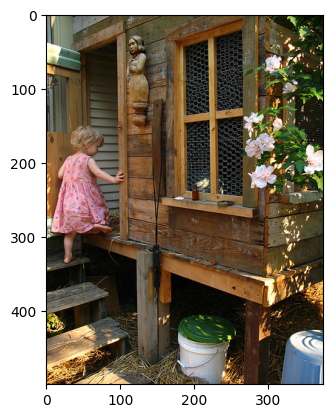

In [74]:
im = Image.open(image_path)
plt.imshow(im)
plt.show()

In [75]:
def encode_image(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

def image_query(query, image_path):
    response = client.chat.completions.create(
        model='gpt-4.1-mini',
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": query,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encode_image(image_path)}",
                },
                }
            ],
            }
        ],
        max_tokens=300,
    )
    # Extract relevant features from the response
    return response.choices[0].message.content
image_query('Write a short label of what is show in this image?', image_path)

'A young child in a pink dress climbing wooden steps to enter a rustic wooden playhouse adorned with a carved figure and surrounded by blooming flowers.'

In [76]:
torch.cuda.empty_cache()

In [77]:
image_search_embedding = get_features_smart([image_path])
distances, indices = index.search(image_search_embedding.reshape(1, -1), 2) #2 signifies the number of topmost similar images to bring back
distances = distances[0]
indices = indices[0]
indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1], reverse=True)

0


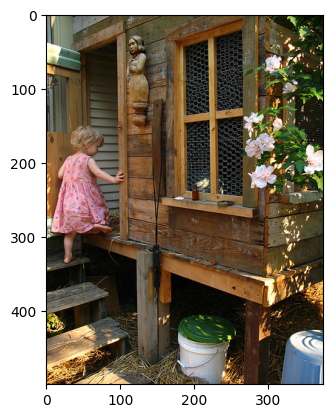

7722


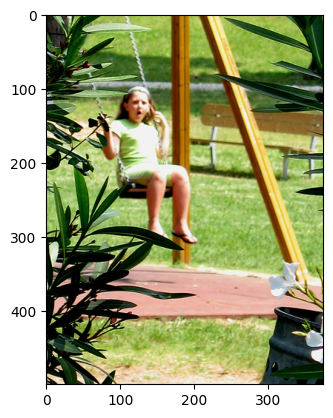

In [78]:
#display similar images
for idx, distance in indices_distances:
    print(idx)
    path = get_image_paths(direc, idx)[0]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()

In [79]:
data

['image,caption\n',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o

In [80]:
similar_path = get_image_paths(direc, indices_distances[0][0])[0]
print(f"similar_path: {similar_path}")
element = find_entry(data, image_path, similar_path)

print(element)

user_query = 'Write a short label of what is shown in this image?'
prompt = f"""
Below is a user query, I want you to answer the query using the description and image provided.

user query:
{user_query}

description:
{element['description']}
"""
image_query(prompt, similar_path)

similar_path: C:/AI_Assisstant/test_dataset/Images\1000268201_693b08cb0e.jpg
C:/AI_Assisstant/test_dataset/Images\1000268201_693b08cb0e.jpg
{'key': 'C:/AI_Assisstant/test_dataset/Images\\1000268201_693b08cb0e.jpg', 'description': ',A child in a pink dress is climbing up a set of stairs in an entry way .'}


'A child in a pink dress climbing wooden stairs at a rustic entryway with floral decorations.'

In [81]:
text_query = "A man lays on a bench while his dog sits by him"
with torch.no_grad():
    torch.cuda.empty_cache()
    text_query_embedding = model.encode_text(clip.tokenize([text_query]).to(device)).float()

# text_features = model.encode_text(clip.tokenize([query]).to(device))
# text_features = text_features / text_features.norm(dim=-1, keepdim=True)


In [82]:
text_query_embedding_unit_vector = (text_query_embedding/text_query_embedding.norm(dim=-1, keepdim=True)).cpu().numpy()

In [83]:
text_query_embedding

tensor([[-7.2754e-02,  9.0576e-02, -3.2520e-01, -1.5625e-01, -5.1361e-02,
          1.4441e-01, -1.6296e-01, -1.0938e-01, -1.0089e-01,  8.0872e-02,
         -3.5645e-02, -1.5182e-02, -1.1029e-01,  8.6365e-02, -3.6694e-01,
          2.9980e-01, -3.3203e-01, -2.1744e-02, -5.8936e-01, -9.2224e-02,
          2.3755e-01,  6.0120e-02, -2.5665e-02,  7.6111e-02,  3.7085e-01,
         -3.0914e-02, -1.6931e-01,  3.1079e-01, -3.3740e-01,  9.6375e-02,
          4.2041e-01,  2.9883e-01, -3.4009e-01,  7.7896e-03, -2.9028e-01,
         -2.4536e-01,  5.6122e-02,  3.4424e-01, -3.6279e-01,  2.5098e-01,
         -1.4746e-01,  2.3865e-01,  1.4343e-01, -3.1763e-01,  3.3740e-01,
          2.0044e-01,  1.0382e-01, -1.2610e-01, -2.6294e-01, -1.3196e-01,
          3.2910e-01,  1.6272e-01,  7.9407e-02, -3.3398e-01, -1.8799e-01,
         -3.8843e-01,  3.3130e-01,  3.0127e-01, -2.8857e-01,  1.2976e-01,
          9.0698e-02,  7.0312e-02, -3.5492e-02,  2.7612e-01,  1.3489e-01,
         -2.6581e-02, -1.0406e-01,  9.

In [84]:
text_query_embedding_unit_vector

array([[-1.01555185e-02,  1.26432795e-02, -4.53931205e-02,
        -2.18105093e-02, -7.16935284e-03,  2.01576818e-02,
        -2.27476787e-02, -1.52673563e-02, -1.40831135e-02,
         1.12886429e-02, -4.97552240e-03, -2.11928296e-03,
        -1.53951524e-02,  1.20554185e-02, -5.12206182e-02,
         4.18489128e-02, -4.63473313e-02, -3.03515396e-03,
        -8.22665170e-02, -1.28733125e-02,  3.31587903e-02,
         8.39193445e-03, -3.58254649e-03,  1.06241032e-02,
         5.17658815e-02, -4.31524310e-03, -2.36337315e-02,
         4.33824658e-02, -4.70970683e-02,  1.34526538e-02,
         5.86839020e-02,  4.17126007e-02, -4.74719368e-02,
         1.08733051e-03, -4.05198373e-02, -3.42493169e-02,
         7.83389155e-03,  4.80512790e-02, -5.06412759e-02,
         3.50331292e-02, -2.05836687e-02,  3.33121456e-02,
         2.00213660e-02, -4.43366766e-02,  4.70970683e-02,
         2.79787946e-02,  1.44920610e-02, -1.76017620e-02,
        -3.67029980e-02, -1.84196569e-02,  4.59383838e-0

In [85]:
# image_search_embedding = get_features_smart([image_path])
distances, indices = index.search(text_query_embedding_unit_vector, 2) #2 signifies the number of topmost similar images to bring back
distances = distances[0]
indices = indices[0]
indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1], reverse=True)

3


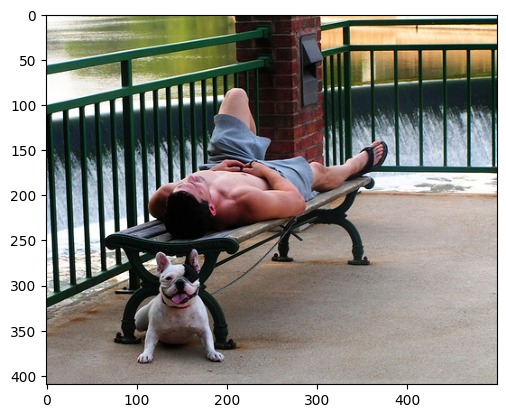

2966


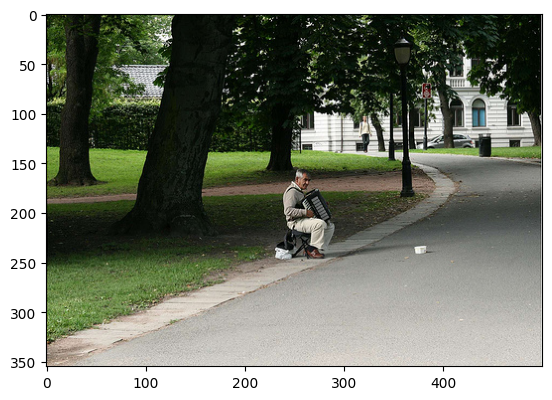

In [86]:
#display similar images
for idx, distance in indices_distances:
    print(idx)
    path = get_image_paths(direc, idx)[0]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()

In [ ]:
# import requests

In [ ]:
# requests.get("https://www.googleapis.com/auth/photospicker.mediaitems.readonly")

<Response [404]>

In [14]:
image_datapath = "C:/AI_Assisstant/app/data/images"
# caption_datapath = "C:/AI_Assisstant/test_dataset/captions.txt/captions.txt"

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
# model, preprocess = clip.load("RN50", device="cpu")

In [7]:
def get_image_paths(directory: str, number: int = None) -> List[str]:
    image_paths = []
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            # print(filename)
            image_paths.append(os.path.join(directory, filename))
            if number is not None and count == number:
                return [image_paths[-1]]
            count += 1
    return image_paths
direc = "C:/AI_Assisstant/app/data/images"
image_paths = get_image_paths(direc)

In [8]:
image_paths.__len__()

206

In [9]:
torch.cuda.empty_cache()

In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

def get_features_smart(image_paths, max_batch=16):
    """
    Extract CLIP image features with dynamic batching to avoid OOM.
    
    image_paths : list of str -> paths to images
    model       : CLIP model
    preprocess  : CLIP preprocess function
    device      : 'cuda' or 'cpu'
    max_batch   : max batch size to try
    """
    torch.cuda.empty_cache()
    # Preprocess all images
    images = [preprocess(Image.open(p).convert("RGB")) for p in image_paths]
    images = torch.stack(images)
    
    dataset = TensorDataset(images)
    
    # Start from max_batch, reduce if OOM occurs
    batch_size = min(max_batch, len(dataset))
    
    while batch_size > 0:
        try:
            dataloader = DataLoader(dataset, batch_size=batch_size)
            all_features = []
            
            with torch.no_grad():
                for (batch,) in dataloader:
                    batch = batch.to(device)
                    features = model.encode_image(batch).float()
                    all_features.append(features.cpu())  # move to CPU to save VRAM
                    
            return torch.cat(all_features, dim=0)
        
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"OOM with batch_size={batch_size}, reducing batch size...")
                batch_size = batch_size // 2
                torch.cuda.empty_cache()
            else:
                raise e
    
    raise RuntimeError("Could not process images even with batch_size=1")

# Usage
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

image_features = get_features_smart(image_paths)
print(image_features.shape)
torch.cuda.empty_cache()


torch.Size([206, 512])


In [11]:
index = faiss.IndexFlatIP(image_features.shape[1])
# index.add(image_features)
index.add(image_features/image_features.norm(dim=-1, keepdim=True).cpu().numpy())
write_index(index, "app_image_index.index")

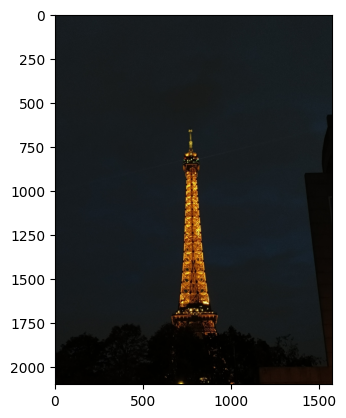

In [ ]:
# image_path = os.path.join(image_datapath, '1000268201_693b08cb0e.jpg')
im = Image.open("C:/AI_Assisstant/app/data/images/IMG_20241020_191952.jpg")
plt.imshow(im)
plt.show()

In [20]:
def encode_image(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

def image_query(query, image_path):
    response = client.chat.completions.create(
        model='gpt-4.1-mini',
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": query,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encode_image(image_path)}",
                },
                }
            ],
            }
        ],
        max_tokens=300,
    )
    # Extract relevant features from the response
    return response.choices[0].message.content
image_query('Write a short label of what is show in this image?', "C:/AI_Assisstant/app/data/images/IMG_20241020_191952.jpg")

'The image shows the Eiffel Tower illuminated at night against a dark sky.'

In [21]:
torch.cuda.empty_cache()

In [24]:
image_search_embedding = get_features_smart(["C:/AI_Assisstant/app/data/images/IMG_20241020_191952.jpg"])
distances, indices = index.search(image_search_embedding.reshape(1, -1), 5) #2 signifies the number of topmost similar images to bring back
distances = distances[0]
indices = indices[0]
indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1], reverse=True)

14


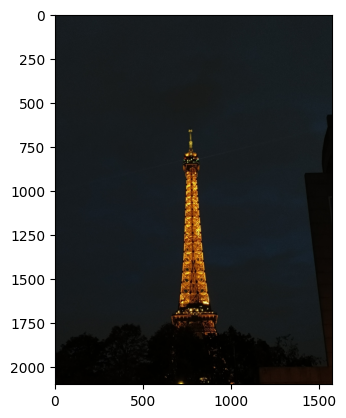

13


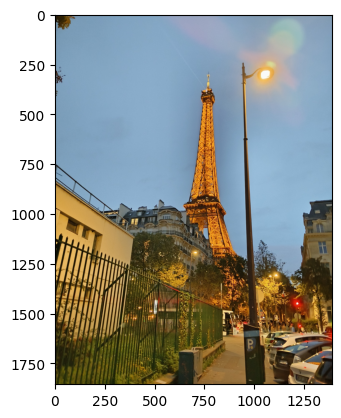

12


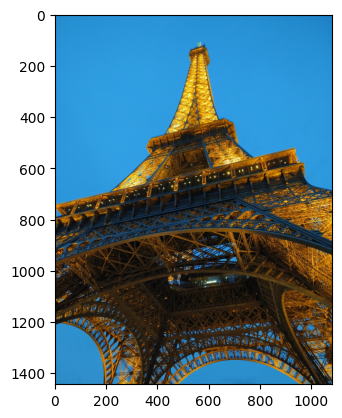

8


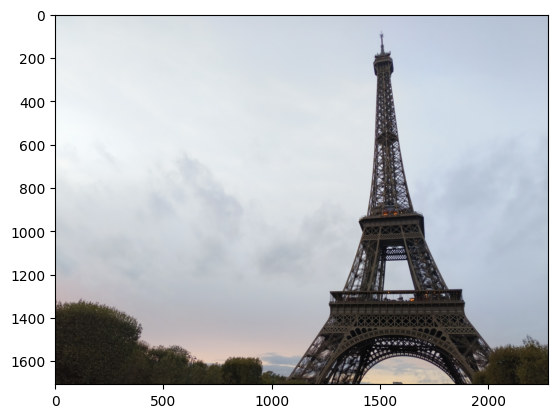

165


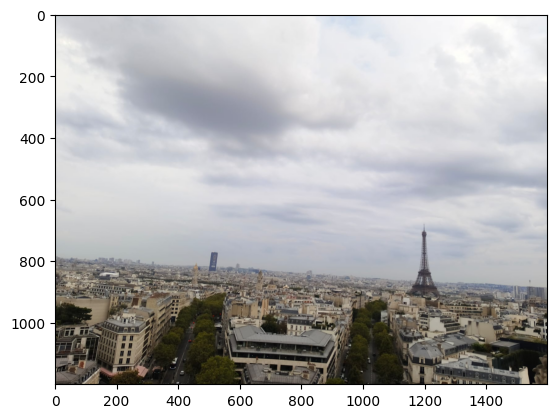

In [25]:
#display similar images
for idx, distance in indices_distances:
    print(idx)
    path = get_image_paths(direc, idx)[0]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()

In [66]:
text_query = "Boy and Mona Lisa"
with torch.no_grad():
    torch.cuda.empty_cache()
    text_query_embedding = model.encode_text(clip.tokenize([text_query]).to(device)).float()

# text_features = model.encode_text(clip.tokenize([query]).to(device))
# text_features = text_features / text_features.norm(dim=-1, keepdim=True)


In [67]:
text_query_embedding_unit_vector = (text_query_embedding/text_query_embedding.norm(dim=-1, keepdim=True)).cpu().numpy()

In [68]:
# image_search_embedding = get_features_smart([image_path])
distances, indices = index.search(text_query_embedding_unit_vector, 5) #2 signifies the number of topmost similar images to bring back
distances = distances[0]
indices = indices[0]
indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1], reverse=True)

143


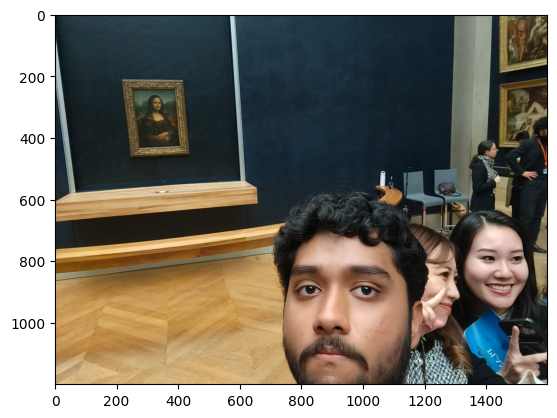

140


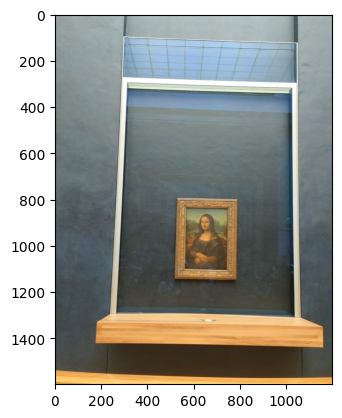

141


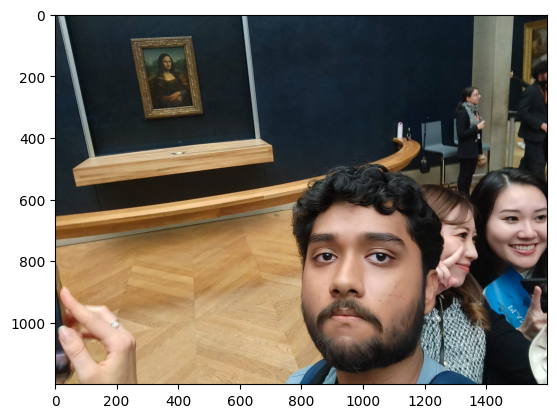

139


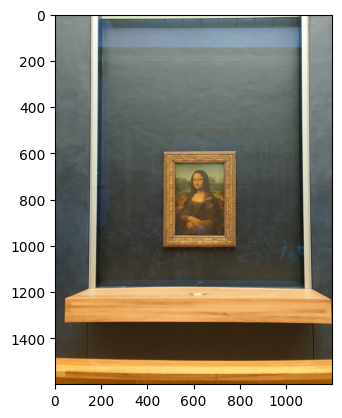

150


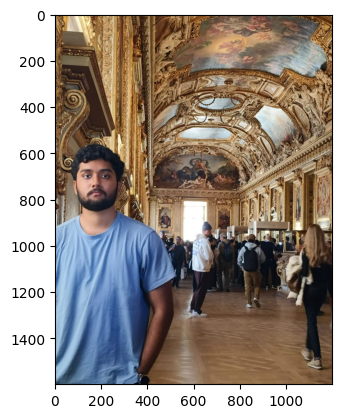

In [69]:
#display similar images
for idx, distance in indices_distances:
    print(idx)
    path = get_image_paths(direc, idx)[0]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()